# US births 1994-2003- time series analysis using Prophet

I will analyze dataset containing information about births in US in 1994-2003. I would like to see if births can be accurately predicted using time only. I will try to find out what's births trend and see if number of births differs depending on month, day, holidays. In my analysis I will use Prophet tool provided by Facebook. 

### Data frame creation and correctness check

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics

In [2]:
# create df
births=pd.read_csv('births.csv')
births.head()

,year,month,date_of_month,day_of_week,births
0,1994,1,1,6,8096
1,1994,1,2,7,7772
2,1994,1,3,1,10142
3,1994,1,4,2,11248
4,1994,1,5,3,11053


In [3]:
# check missing data
births.isnull().any()

year             False
month            False
date_of_month    False
day_of_week      False
births           False
dtype: bool

In [4]:
# check duplicates
births.duplicated().any()

False

In [5]:
# check distribution
births['births'].describe()

count     3652.000000
mean     10876.817360
std       1858.566631
min       6443.000000
25%       8844.500000
50%      11615.000000
75%      12274.250000
max      14540.000000
Name: births, dtype: float64

No missing values nor duplicates. Low standard deviation. Min, max value not far from mean. Data seems to be corrent. No need to analyze outliers.

In [6]:
# create one column with date
births.rename(columns={'date_of_month': 'day'}, inplace=True)
births['date']=pd.to_datetime(births[['year','month','day']])

I have 10 years of data. I will use 8 years to train model and 2 to test correctness

In [7]:
# create train and test df in the format required by Prophet
train = births[births['year']<2002]
test = births[births['year']>=2002]
train = pd.DataFrame({'ds': train['date'], 'y': train['births']})
test = pd.DataFrame({'ds': test['date'], 'y': test['births']})
print(train.sample(5))
print(test.sample(5))

             ds      y
552  1995-07-07  12954
258  1994-09-16  12884
2565 2001-01-09  12105
1635 1998-06-24  12246
1011 1996-10-08  12311
             ds      y
3430 2003-05-24   8678
3089 2002-06-17  11482
2980 2002-02-28  12096
3308 2003-01-22  11835
3460 2003-06-23  12012


### Model creation

I will start by modeling data using default Prophet parameters

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


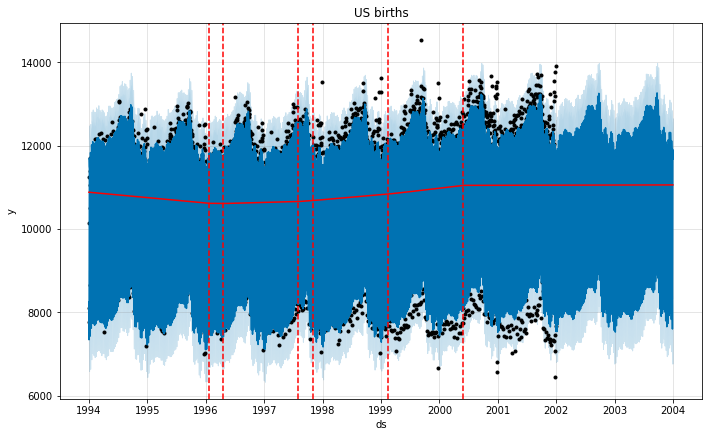

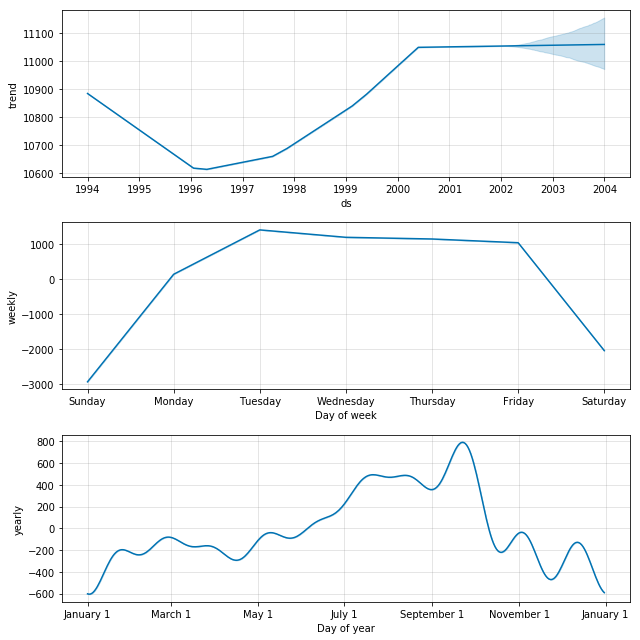

In [8]:
# create Prophet model with default parameters, predict birhts 2 years
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [9]:
# add absolute error calculation to test df
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])

In [10]:
# create function to measure means absolute error and mean absolute percentage error
def results(df):
    mae=df['absolute_error'].mean()
    mape= mae/df['y'].mean()
    print ('mae:{:.3f}'.format(mae))
    print ('mape:{:.3f}'.format(mape))      

In [11]:
# calculate mae and mape of first model
results(test)

mae:559.890
mape:0.050


Model predicts birhts in US for 2002 and 2003 with 5% error rate. It's a really good start. I'll try to improve the model.

 I will add to model US holidays that are predefined in Prophet.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


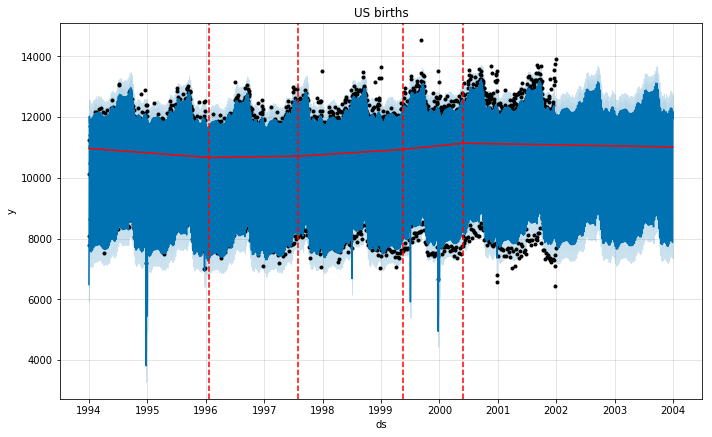

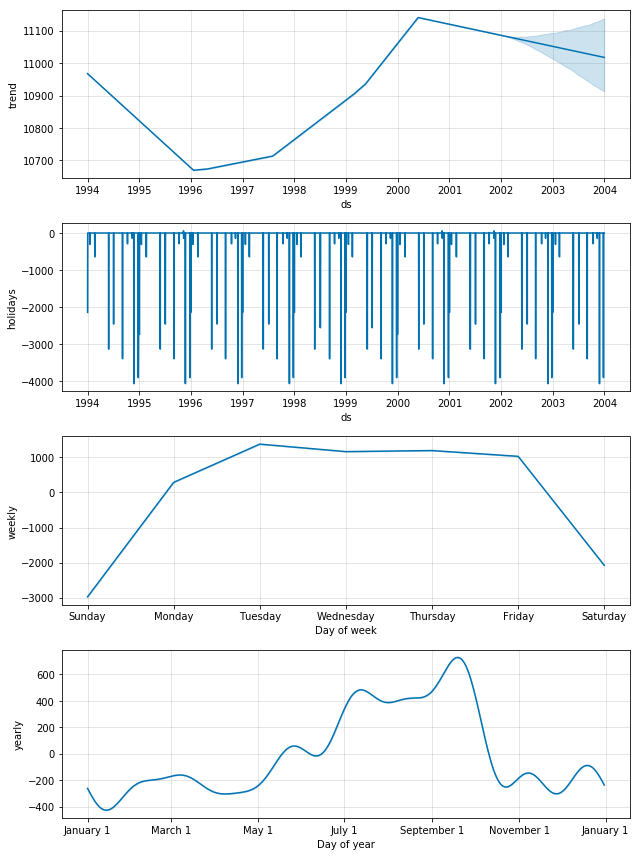

In [12]:
# add US holidays to model
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [13]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:491.273
mape:0.044


Holidays do affect the number of daily birhts. As I can see from the graph there are less births on the holidays. Error rate was reduced to 4.4%

I can see that calculated trend is very unstable. It was increasing in first model. Now it's decreasing. By default Prophet detects trend changepoints (change in trend rate or change from increasing to deacreasing trend and the other way round)  in the first 80% of data and fit the trendline on each section between changepoints. Trend for the future is based on the last 20% of the data. I will change to boundary to 70% to obtain more solid trend prediction.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


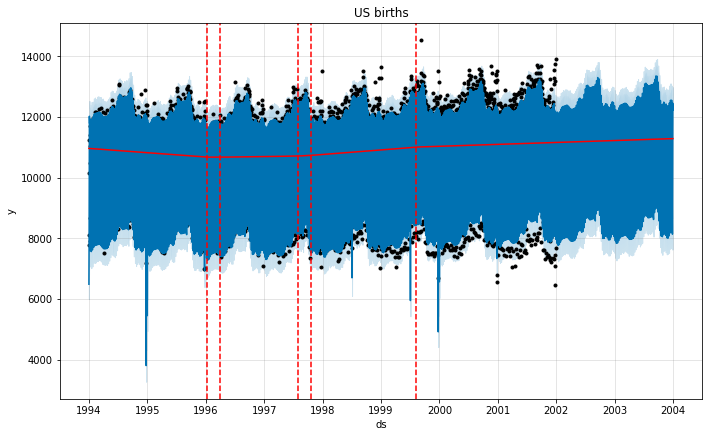

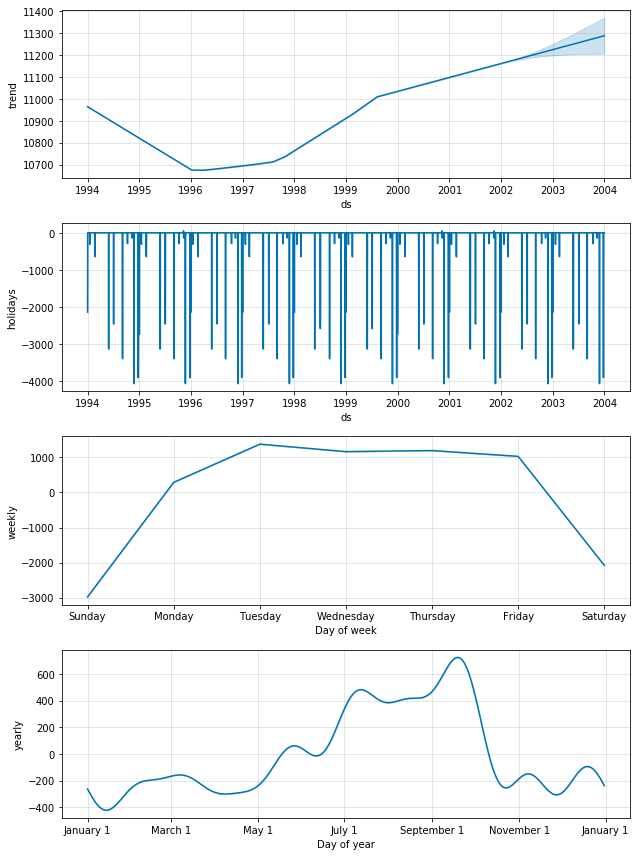

In [14]:
# change changepoint range to 70%
m = Prophet(changepoint_range=0.7)
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [15]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:454.267
mape:0.041


Now forecasted trend is slighly increasing. The error rate was reduced to 4.1%

By default, Prophet uses a linear model for its forecast. I will check if logistic regression improves results. To do it I have to specify maximum capacity- the trend maximum boundary

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


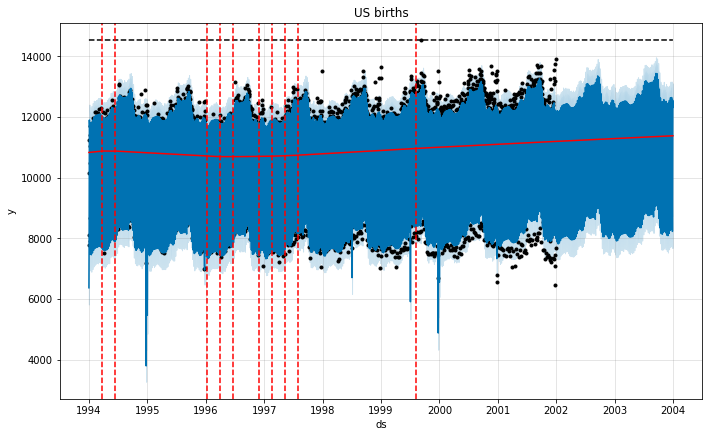

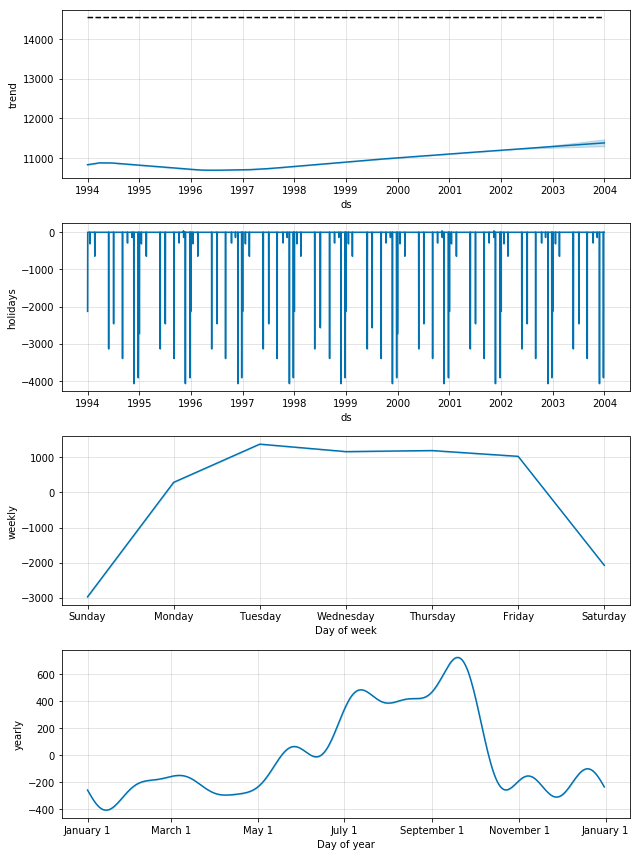

In [16]:
# change growth to logistic
train['cap']=train['y'].max()
m = Prophet(changepoint_range=0.7, growth='logistic')
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['cap'] = train['y'].max()
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [17]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:449.555
mape:0.040


The difference is not big, but again error rate was slightly reduced. The trend line is now smooth and more stable. As the result the uncertainty area (the blue shade o the graphs) was significantly reduced.

On the forecast graph I can see that forecast line is a good fit in first years but later there are more points outside the forecast line. By default the seasonality effect is added to the trend. But there is an option to change it to multiplicative mode so as seasonality effect (amplitude) increases or decreases with trend. It should be a solution in this situation.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


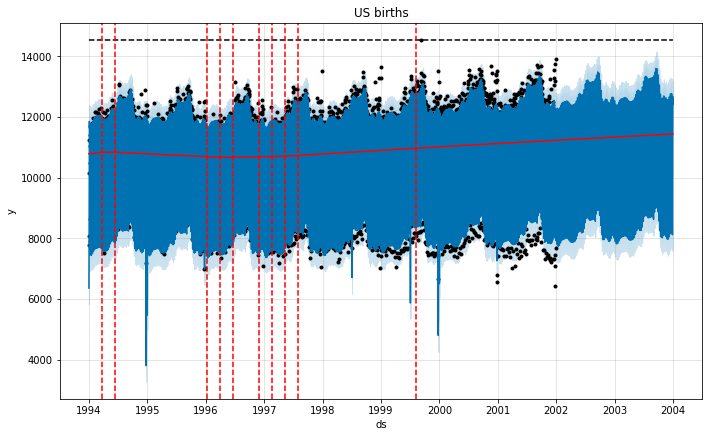

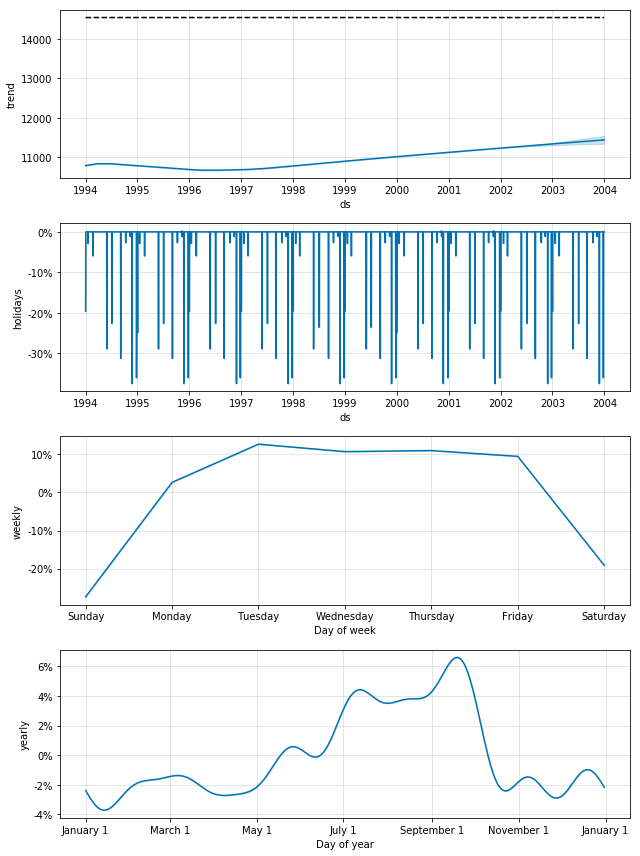

In [18]:
# change seasonality mode to multiplicative
train['cap']=train['y'].max()
m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['cap'] = train['y'].max()
forecast = m.predict(future)
fig1 = m.plot(forecast) 
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [19]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:408.110
mape:0.037


The error rate decreased to 3.7%.

In any Machine Learning model there is a bias variance tradeoff. One of the indicators in Prophet that enable to manage it is yearly_seasonality. Seasonalities are estimated using a partial Fourier sum. Seasonality change more or less quickly depending on the number of terms in the partial sum. I will check a few options of this parameters to see if it can improve the result.

In [20]:
# look for optimal yearly_seasonality
temp=pd.DataFrame(columns=['yearly_seasonality','mae','mape'])
for i in [5,8,12,15]:
    train['cap']=train['y'].max()
    m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative', yearly_seasonality=i)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    future = m.make_future_dataframe(periods=730)
    future['cap'] = train['y'].max()
    forecast = m.predict(future)
    test['yhat']=forecast['yhat']
    test['absolute_error']=abs(test['y']-test['yhat'])
    mae=test['absolute_error'].mean()
    mape=mae/test['y'].mean()
    result=pd.Series({'yearly_seasonality':i, 'mae':mae, 'mape':mape })
    temp=temp.append(result, ignore_index=True)
temp

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,yearly_seasonality,mae,mape
0,5.0,415.119163,0.037358
1,8.0,409.175398,0.036823
2,12.0,407.661825,0.036687
3,15.0,406.460253,0.036579


The best result was obtained with yearly_seasonality equal to 15. But the difference is very small. Let's see how new forecast would look like

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


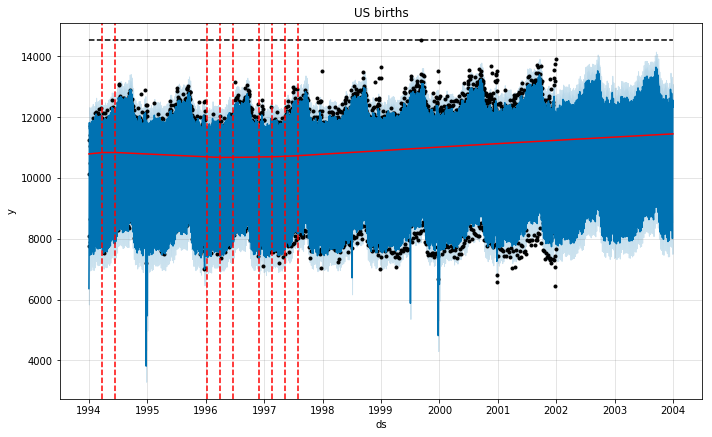

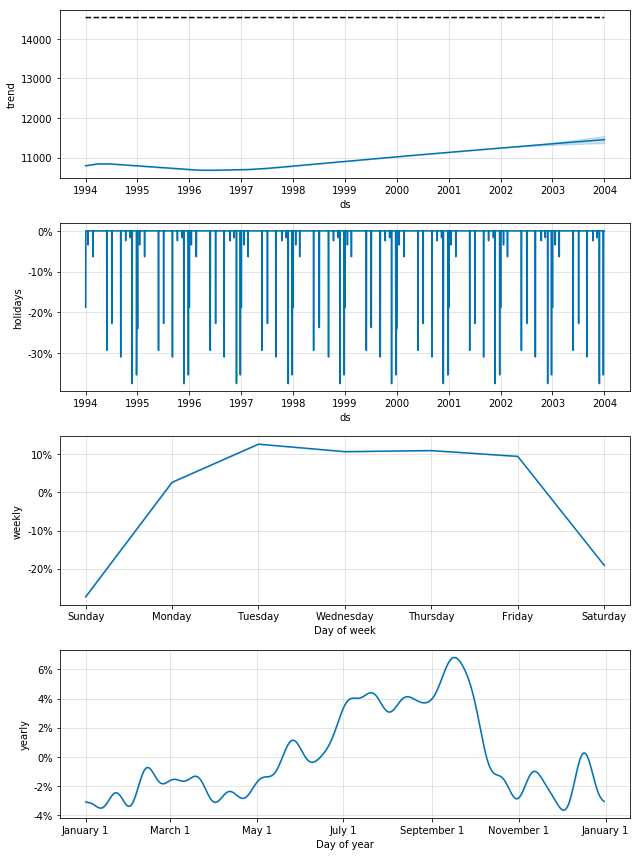

In [21]:
# change seasonality mode to multiplicative
train['cap']=train['y'].max()
m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative', yearly_seasonality=20)
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['cap'] = train['y'].max()
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

The yearly seasonality varies a lot right now. The accuracy increase is so small that I prefer to get back to the default parameter of yearly_seasonality equal to 10 and keep model more simple and interpretable.

I often heard that more children are born during the full moon. Is that right? I'm going to check this.

In [22]:
# create df with dates of fill moon
moon=pd.read_csv('Moon.csv', sep=';')
moon['date']=pd.to_datetime(moon)

I guess that if many childbirths starts during the full moon the increased number of birhts can be observed the day after. I can check influence of both full moon dates and days after by setting upper_window parameter to 1.

In [23]:
# create holidays df in the format required by Prophet, set upper_window to 1
holidays = pd.DataFrame({'holiday': 'full_moon','ds': moon['date'],'lower_window': 0,'upper_window': 1})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


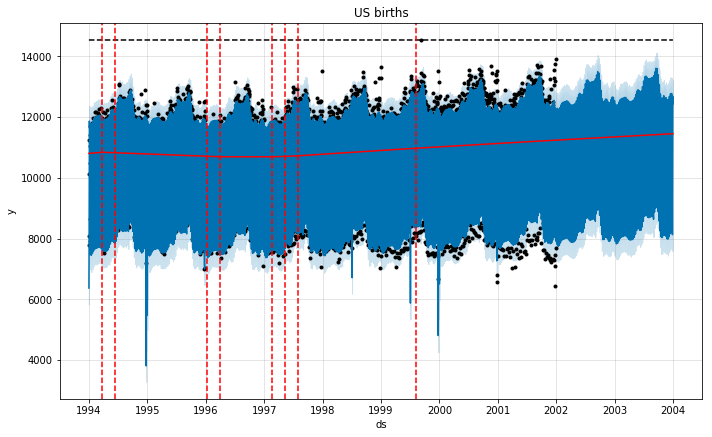

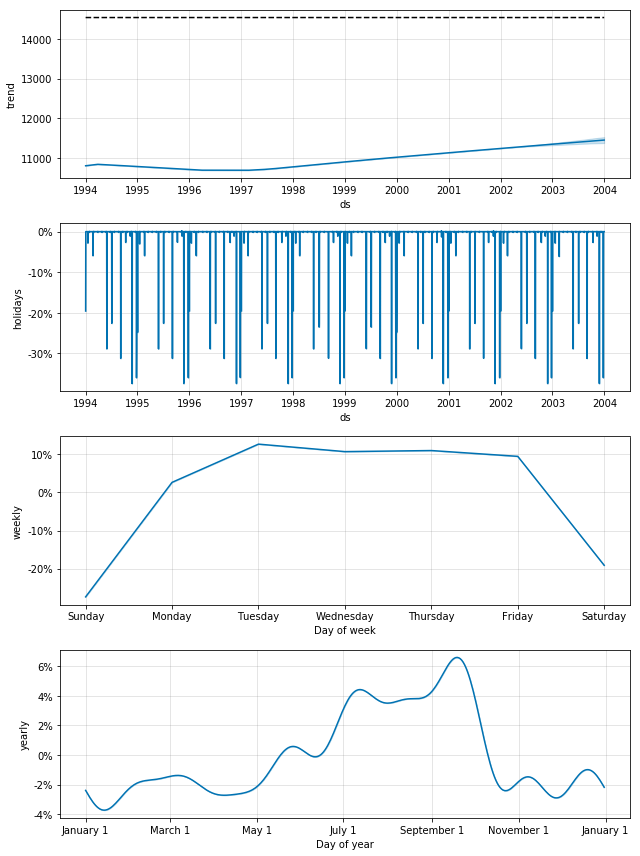

In [24]:
# add full moon dates to model
train['cap']=train['y'].max()
m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative', holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['cap'] = train['y'].max()
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [25]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:408.580
mape:0.037


In [26]:
# check percentage influence of full moon on birhts
forecast[forecast['full_moon']!=0]['full_moon'].head(2)

26   -0.001914
27    0.000531
Name: full_moon, dtype: float64

The accuracy of model did not increase. According to model there are 0,2% less births on days with full moon and 0,05% more the day after. I will not carry on full hypothesis test but number of births seems not be be correlated with full moon.

I will now train again the model obtained so far and analyze if there are some dates other than US holidays that influence daily number of births.

In [27]:
# train model
train['cap']=train['y'].max()
m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['cap'] = train['y'].max()
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# find days of year with the highest mean absolute error
train['yhat']=forecast['yhat']
train['absolute_error']=abs(train['y']-train['yhat'])
train['holidays']=forecast['holidays']
temp=train[train['holidays']==0].groupby([train['ds'].dt.month,train['ds'].dt.day]).mean()
temp[temp['absolute_error']>temp['absolute_error'].quantile(0.97)]

y      cap          yhat  absolute_error  holidays
ds ds                                                               
1  2    8953.857143  14540.0  10147.471373     1275.717253       0.0
2  29  11168.500000  14540.0  11988.781413      820.281413       0.0
7  5   10588.857143  14540.0  11420.852972      831.995829       0.0
10 31   9794.625000  14540.0  10861.988091     1067.363091       0.0
11 23  10291.333333  14540.0  10420.454177      865.958154       0.0
   24  10023.857143  14540.0  10588.758608     1135.301784       0.0
12 23   9740.750000  14540.0  10509.880615      776.956903       0.0
   24   7979.000000  14540.0  10183.058982     2204.058982       0.0
   26   9402.142857  14540.0  10920.766983     1518.624126       0.0
   28  11810.375000  14540.0  10887.052391      923.322609       0.0
   29  11707.500000  14540.0  10835.351032      872.148968       0.0

Number of birhts is significantly decreased on 2nd of January- day after New Year, 29th of February- last day of February on leap years, 5th of July- day after Indpendence day, 31st of October- Halloween. High absolute error is also observed in December around Christmas and at the end of November.  

I will have a look on the dates with the highest abosulte error without grouping it by year to see if I can found any more useful information

In [29]:
# find days of year with the highest mean absolute error
train[train['absolute_error']>train['absolute_error'].quantile(0.99)]

,ds,y,cap,yhat,absolute_error,holidays
0,1994-01-01,8096,14540,6365.181744,1730.818256,-0.195773
328,1994-11-25,9419,14540,11517.541281,2098.541281,0.000000
358,1994-12-25,7192,14540,3810.547052,3381.452948,-0.360175
365,1995-01-01,7828,14540,5473.501082,2354.498918,-0.195773
367,1995-01-03,9999,14540,11874.264718,1875.264718,0.000000
692,1995-11-24,9125,14540,11420.671379,2295.671379,0.000000
724,1995-12-26,9447,14540,11904.535096,2457.535096,0.000000
731,1996-01-02,9408,14540,11788.520629,2380.520629,0.000000
1063,1996-11-29,9302,14540,11394.492948,2092.492948,0.000000
1088,1996-12-24,9114,14540,11915.232394,2801.232394,0.000000


In each November there is a day between 23rd and 29th that has a big absolute error. I checked it in calendar and realized that it's day following Thanksgiving Day- Black Friday. Now I will have a deeper look on December data

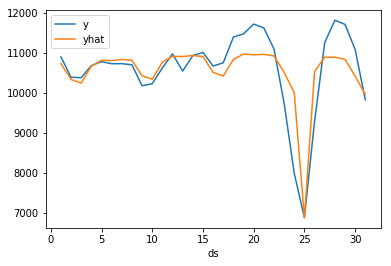

In [30]:
# plot December real and predicted data
temp=train[train.ds.dt.month==12]
temp.groupby(temp.ds.dt.day)[['y','yhat']].mean().plot()

In [31]:
# compare December real and predicted data
temp.groupby(temp.ds.dt.day)[['y','yhat']].mean()

,y,yhat
ds,,
1,10895.250,10727.362778
2,10387.875,10332.322380
3,10376.500,10242.296012
4,10679.500,10665.375427
5,10775.625,10809.258435
6,10724.875,10803.838566
7,10726.625,10831.729990
8,10698.000,10811.209730
9,10174.125,10423.305428


I can see that prediction is overestimated for 23rd, 24th, 26th of December and underestimated between 18th-22nd and 27nd-30th. 25th of December is marked as holiday so the prediction for this date is corrected already.

I will now add all mentioned dates to the model. I'll add single days to holidays function and period around Christmas when prediction as additional regressors- one with dates when prediction is underestimated and one when prediction is overestimated.

In [32]:
# create holidays df with additional dates
halloween = pd.DataFrame({'holiday': 'Halloween','ds': ['10-31-1994', '10-31-1995', '10-31-1996', '10-31-1997', '10-31-1998', 
                                                        '10-31-1999', '10-31-2000', '10-31-2001', '10-31-2002', '10-31-2003' ]})
black_friday = pd.DataFrame({'holiday': 'Black_Friday','ds': ['11-25-1994', '11-24-1995', '11-29-1996', '11-28-1997',
                                                              '11-27-1998', '11-26-1999', '11-24-2000', '11-23-2001',  
                                                              '11-29-2002', '11-28-2003']})
leap_year = pd.DataFrame({'holiday': 'Leap_Year','ds': ['02-29-1996', '02-29-2000']})
jan_2nd = pd.DataFrame({'holiday': 'Jan_2nd','ds': ['01-02-1994', '01-02-1995', '01-02-1996', '01-02-1997', 
                                                    '01-02-1998', '01-02-1999', '01-02-2000', '01-02-2001', 
                                                    '01-02-2002', '01-02-2003']})
jul_5th = pd.DataFrame({'holiday': 'Jul_5th','ds': ['07-05-1994', '07-05-1995', '07-05-1996', '07-05-1997', 
                                                    '07-05-1998', '07-05-1999', '07-05-2000', '07-05-2001', 
                                                    '07-05-2002', '07-05-2003']})
holidays=pd.concat((halloween, black_friday, leap_year, jan_2nd, jul_5th),axis=0, sort=False)

In [33]:
# create function to add christmas period to df
def christmas_period_upper(ds):
    if ds.month == 12 and ds.day in [17,18,19,20,21,22,27,28,29,30]:
        return 1
    else:
        return 0

In [34]:
# create function to add christmas period to df
def christmas_period_lower(ds):
    if ds.month == 12 and ds.day in [23,24,26]:
        return 1
    else:
        return 0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


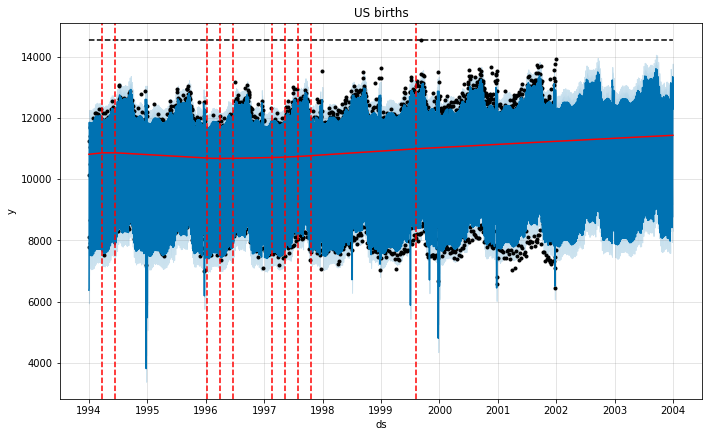

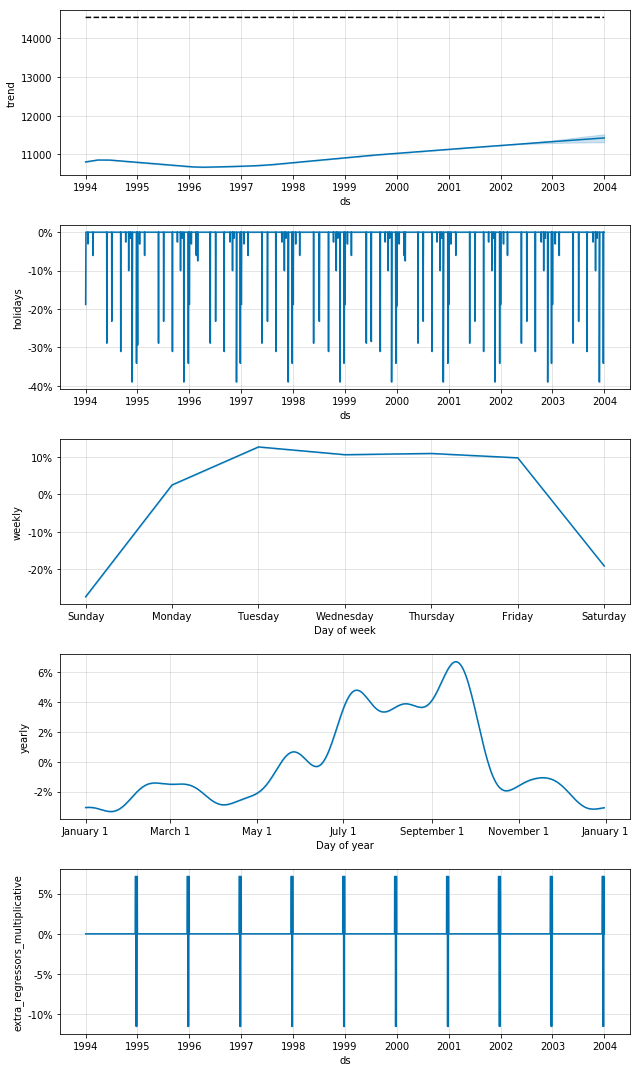

In [35]:
# add additional holidays to the model
train['cap']=train['y'].max()
train['christmas_period_upper']=train['ds'].apply(christmas_period_upper)
train['christmas_period_lower']=train['ds'].apply(christmas_period_lower)
m = Prophet(changepoint_range=0.7, growth='logistic', seasonality_mode='multiplicative', holidays=holidays)
m.add_country_holidays(country_name='US')
m.add_regressor('christmas_period_upper')
m.add_regressor('christmas_period_lower')
m.fit(train)
future = m.make_future_dataframe(periods=730)
future['christmas_period_upper']=future['ds'].apply(christmas_period_upper)
future['christmas_period_lower']=future['ds'].apply(christmas_period_lower)
future['cap'] = train['y'].max()
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('US births')
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast)

In [36]:
# measure results
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])
results(test)

mae:382.513
mape:0.034


Error rate was reduced to 3,4% I'll now check if prediction for December looks better now.

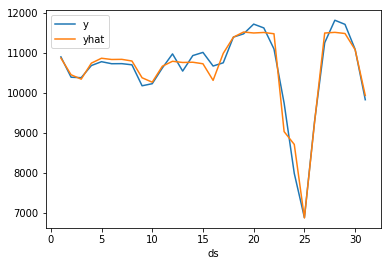

In [37]:
# plot December real and predicted values
train['yhat']=forecast['yhat']
temp=train[train.ds.dt.month==12]
temp.groupby(temp.ds.dt.day)[['y','yhat']].mean().plot()

Yes, model now definetely better catches December fluctuations.

I'll now plot predictions vs real data for a few years to see how well model fit the data

Text(0.5, 1.0, 'Prediction vs. real birhts 2001')

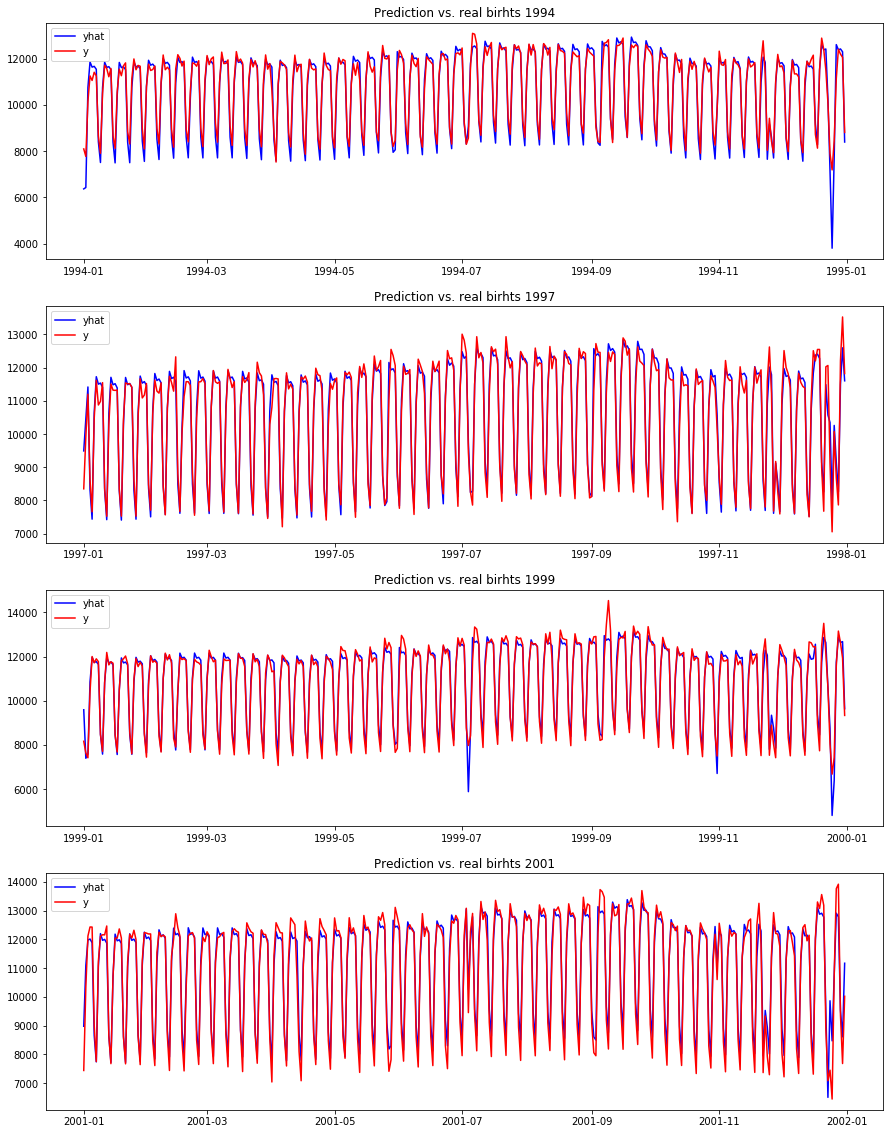

In [38]:
# Plot real data vs. predictions for 1994, 1997, 1999, 2001 
train['yhat']=forecast['yhat']
fig, ax= plt.subplots(4,1,figsize=(15,20))
train1994=train[train.ds.dt.year==1994]
train1997=train[train.ds.dt.year==1997]
train1999=train[train.ds.dt.year==1999]
train2001=train[train.ds.dt.year==2001]
ax[0].plot(train1994['ds'], train1994['yhat'], color='blue', linestyle='-')
ax[0].plot(train1994['ds'], train1994['y'], color='red', linestyle='-')
ax[0].legend()
ax[0].set_title('Prediction vs. real birhts 1994')
ax[1].plot(train1997['ds'], train1997['yhat'], color='blue', linestyle='-')
ax[1].plot(train1997['ds'], train1997['y'], color='red', linestyle='-')
ax[1].legend()
ax[1].set_title('Prediction vs. real birhts 1997')
ax[2].plot(train1999['ds'], train1999['yhat'], color='blue', linestyle='-')
ax[2].plot(train1999['ds'], train1999['y'], color='red', linestyle='-')
ax[2].legend()
ax[2].set_title('Prediction vs. real birhts 1999')
ax[3].plot(train2001['ds'], train2001['yhat'], color='blue', linestyle='-')
ax[3].plot(train2001['ds'], train2001['y'], color='red', linestyle='-')
ax[3].legend()
ax[3].set_title('Prediction vs. real birhts 2001')

Model fits data really well. But I can see that weekly seasonality fits data well in the middle of my training period, but in the first  year amplitude is too high and in the last is too small. I chose in model multiplicative seasonality- seasonality effects increases when trend increasesthe weekly seasonality but it seems not to be enough. The seasonality fluctuations increase in a faster rate than the trend. Let's analyze it further.

In [39]:
# Measure how proporions of y to yhat changes in time on different days of week
train['proportion']=train['y']/train['yhat']
temp=train.groupby([train['ds'].dt.year,train['ds'].dt.dayofweek])['proportion'].mean().unstack()
temp

ds,0,1,2,3,4,5,6
ds,,,,,,,
1994,1.008770,0.992646,0.990814,0.989888,0.998800,1.030589,1.067798
1995,0.998185,0.987945,0.992067,0.994385,0.998608,1.019799,1.040230
1996,0.999202,0.990990,0.995006,0.995922,0.999984,1.012780,1.021549
1997,0.997762,1.001796,0.990962,0.989111,0.998410,0.998161,0.995010
1998,0.999241,1.010904,1.004870,0.996204,0.995350,1.005597,0.992996
1999,0.994963,1.002047,1.000787,1.002734,0.991298,0.987706,0.983360
2000,1.008656,1.014056,1.015678,1.017195,1.009519,0.998366,0.982570
2001,0.992217,0.996204,1.006212,1.009857,1.004504,0.962374,0.943102


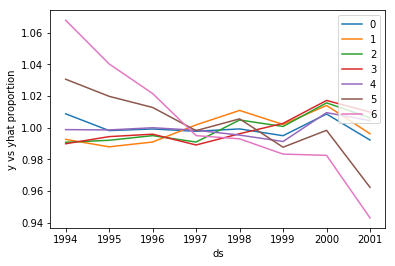

In [40]:
# plot proportions
temp.plot()
plt.ylabel('y vs yhat proportion')
plt.legend(loc='upper right')

I can see that yhat is close to y in 1997, 1998. Predictions are not bad for whole period during the week. But on weekends model is underestimating y in first years and overestimating in last years. The mean difference is up to 6%. I will accelerate the influence of seasonality efect in time. I will leave predictions for the middle date of my dataset- 31-12-1997 as they are. Then for each date I'll calculate how far is it from the middle date. I will multiply the multiplicative_term used in model by 'number of days from the middle' times new variable called accelerator. This will decrease seasonality efect in the past and increase in the future. I will look for optimal accelerator value that minimizes mean absolute error on train set, as test set can be only used to measure final results not to tune parameters.

In [41]:
# calculate mae for train set before adding accelerator
train['yhat']=forecast['yhat']
train['absolute_error']=abs(train['y']-train['yhat'])
results(train)

mae:232.761
mape:0.022


In [42]:
# try diffeent values of accelerator and look for best result
forecast['days_from_middle']=(forecast['ds']-pd.to_datetime('31-12-1997')).dt.days
temp=pd.DataFrame(columns=['accelerator','mae'])
for i in [0.000001, 0.00001, 0.0001, 0.001]:
    forecast['yhat']=forecast['trend']*(1+forecast['multiplicative_terms']*(1+forecast['days_from_middle']*i))
    train['yhat']=forecast['yhat']
    train['absolute_error']=abs(train['y']-train['yhat'])
    mae=train['absolute_error'].mean()
    result=pd.Series({'accelerator':i, 'mae':mae})
    temp=temp.append(result, ignore_index=True)
temp

,accelerator,mae
0,0.000001,232.195501
1,0.000010,227.321504
2,0.000100,205.049028
3,0.001000,1045.143460


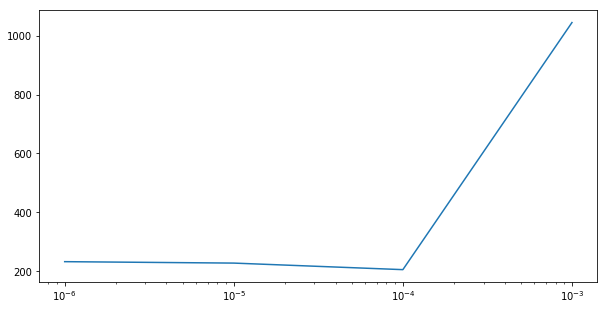

In [43]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(temp['accelerator'], temp['mae'])
plt.xscale('log')

Best resuls is 0.0001. I will check values closer to 0.0001.

In [44]:
# try diffeent values of accelerator and look for best result
forecast['days_from_middle']=(forecast['ds']-pd.to_datetime('31-12-1997')).dt.days
temp=pd.DataFrame(columns=['accelerator','mae'])
for i in [0, 0.000025, 0.00005, 0.0001, 0.0002, 0.0004]:
    forecast['yhat']=forecast['trend']*(1+forecast['multiplicative_terms']*(1+forecast['days_from_middle']*i))
    train['yhat']=forecast['yhat']
    train['absolute_error']=abs(train['y']-train['yhat'])
    mae=train['absolute_error'].mean()
    result=pd.Series({'accelerator':i, 'mae':mae})
    temp=temp.append(result, ignore_index=True)
temp

,accelerator,mae
0,0.000000,232.761088
1,0.000025,220.182948
2,0.000050,211.401765
3,0.000100,205.049028
4,0.000200,246.759193
5,0.000400,418.075695


Text(0, 0.5, 'mae')

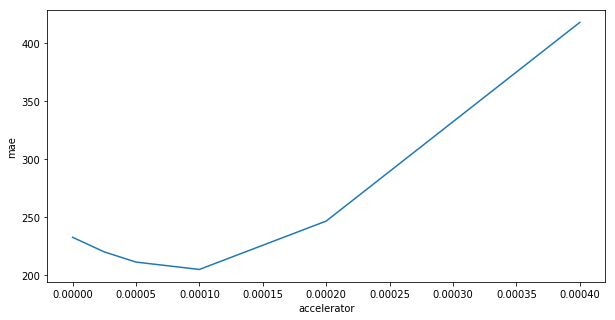

In [45]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(temp['accelerator'], temp['mae'])
plt.xlabel('accelerator')
plt.ylabel('mae')

I decided to use 0.0001 as the value of my accelerator. I will now check the results on the test set

In [46]:
# Multiply 'yhat' by chosen accelerator and update predictions is train and test dataset
forecast['yhat']=forecast['trend']*(1+forecast['multiplicative_terms']*(1+forecast['days_from_middle']*0.0001))
train['yhat']=forecast['yhat']
train['absolute_error']=abs(train['y']-train['yhat'])
test['yhat']=forecast['yhat']
test['absolute_error']=abs(test['y']-test['yhat'])

In [47]:
# measure results on test set
results(test)

mae:256.458
mape:0.023


Wow! The error rate was now reduced from 3.4% to 2.3%. Let's see how forecast vs real values looks like now.

Text(0.5, 1.0, 'Prediction vs. real birhts 2001')

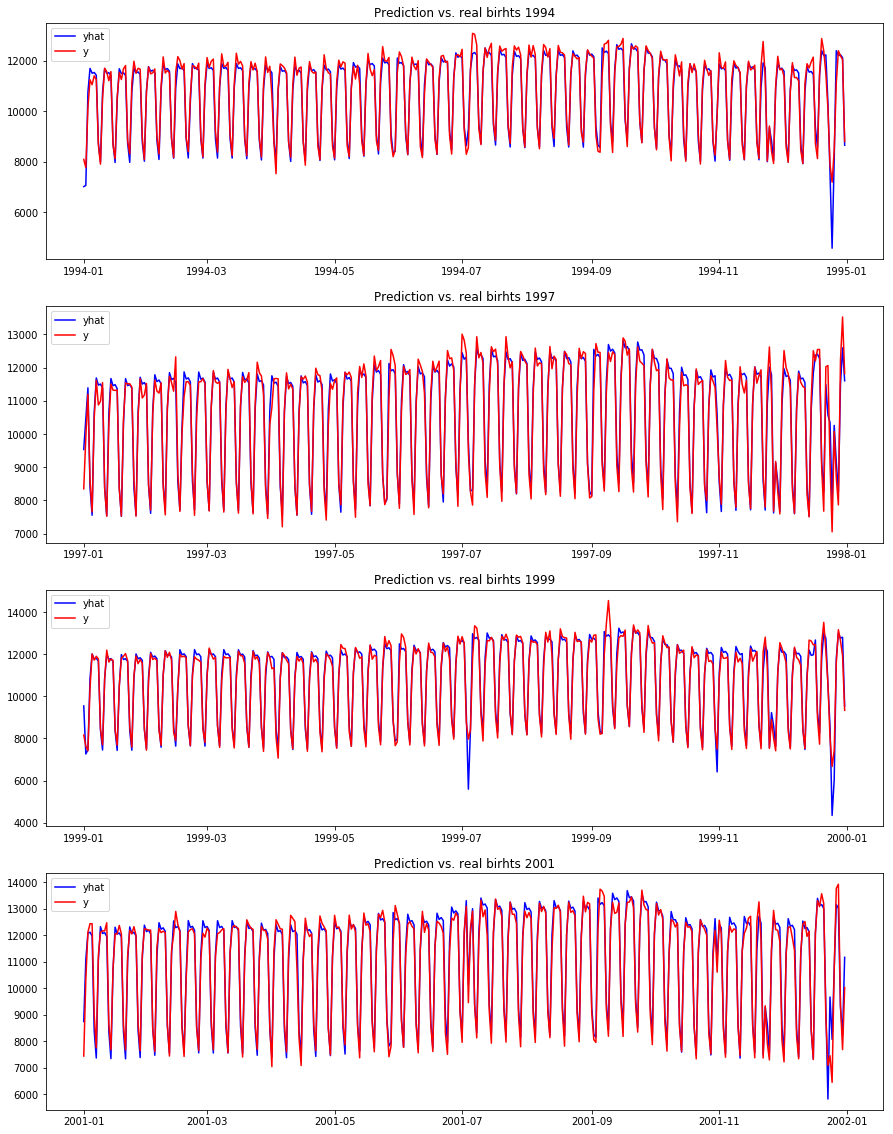

In [48]:
# Plot real data vs. predictions for 1994, 1997, 1999, 2001 after addind accelerator
fig, ax= plt.subplots(4,1,figsize=(15,20))
train1994=train[train.ds.dt.year==1994]
train1997=train[train.ds.dt.year==1997]
train1999=train[train.ds.dt.year==1999]
train2001=train[train.ds.dt.year==2001]
ax[0].plot(train1994['ds'], train1994['yhat'], color='blue', linestyle='-')
ax[0].plot(train1994['ds'], train1994['y'], color='red', linestyle='-')
ax[0].legend()
ax[0].set_title('Prediction vs. real birhts 1994')
ax[1].plot(train1997['ds'], train1997['yhat'], color='blue', linestyle='-')
ax[1].plot(train1997['ds'], train1997['y'], color='red', linestyle='-')
ax[1].legend()
ax[1].set_title('Prediction vs. real birhts 1997')
ax[2].plot(train1999['ds'], train1999['yhat'], color='blue', linestyle='-')
ax[2].plot(train1999['ds'], train1999['y'], color='red', linestyle='-')
ax[2].legend()
ax[2].set_title('Prediction vs. real birhts 1999')
ax[3].plot(train2001['ds'], train2001['yhat'], color='blue', linestyle='-')
ax[3].plot(train2001['ds'], train2001['y'], color='red', linestyle='-')
ax[3].legend()
ax[3].set_title('Prediction vs. real birhts 2001')

Accelerator definetely corrected forecast for first and last years. I will see how prediction for 2002 and 2003 look like.

Text(0.5, 1.0, 'Prediction vs. real birhts 2003')

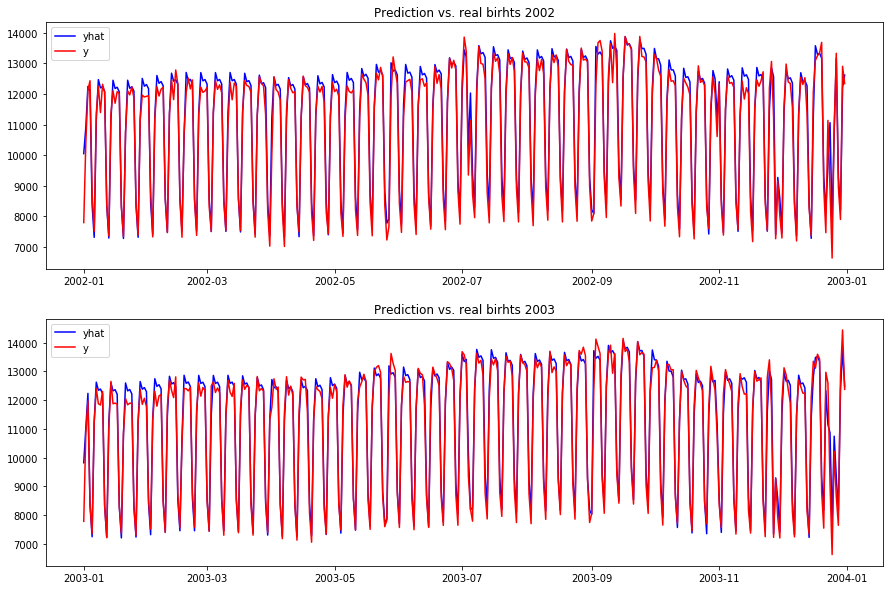

In [49]:
fig, ax= plt.subplots(2,1,figsize=(15,10))
test2002=test[test.ds.dt.year==2002]
test2003=test[test.ds.dt.year==2003]
ax[0].plot(test2002['ds'], test2002['yhat'], color='blue', linestyle='-')
ax[0].plot(test2002['ds'], test2002['y'], color='red', linestyle='-')
ax[0].legend()
ax[0].set_title('Prediction vs. real birhts 2002')
ax[1].plot(test2003['ds'], test2003['yhat'], color='blue', linestyle='-')
ax[1].plot(test2003['ds'], test2003['y'], color='red', linestyle='-')
ax[1].legend()
ax[1].set_title('Prediction vs. real birhts 2003')

The model fits real data really well. The trend is correct and fluctuations are modelled properly. I managed to reduce error rate obtained using default Prophet parameters- 5% to 2.3%. I'm happy with the results. It's time for conclusions.

## Conclusions

Childbearing is a natural process. In theory we cannot predict exact date of childbirth not affect it. If that were true the distribution of daily number of births should be more or less uniform. As the analysis shown the number of births differs a lot during different days of week and is affected by holidays. I believe the reason of this are cesarean deliveries and labor inductions. Sometimes C-sections are carried out due to problems during natural brith giving but in many cases it's known in advance that cesarean delivery will be necessary and than it's usually scheduled for 38-39 week of pregnancy. On the other hand  if the pregnancy has gone past the end of the 41st week the labor induction may be needed. For those reasons part of the dates of the childbirths can be planned and chosen from a few days period what results in seasonality in births distribution. Let's analyse the components of the forecast.

### Trend

I'll calcuale the percentage change of trend over the years,

In [50]:
# calculate percentage change of trend
forecast.groupby(forecast['ds'].dt.year)['trend'].mean().pct_change()

ds
1994         NaN
1995   -0.008811
1996   -0.005515
1997    0.004896
1998    0.010990
1999    0.011353
2000    0.009759
2001    0.009174
2002    0.008890
2003    0.008624
Name: trend, dtype: float64

The trend of births was decreasing between 1994 and 1996 and then started to increase with 1% rate from 1997 to 1998. Then continued to increase but slightly more slowly. It's predicted to be icreasing in 2002 and 2003 by around 0.9%.

### Yearly seasonality

Let's have a look on yearly seasonality effect.

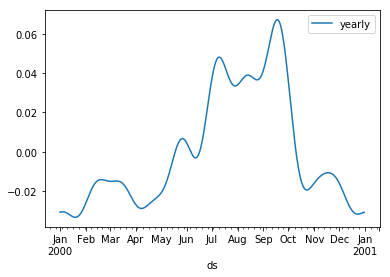

In [51]:
# plot yearly seasonality 
temp=forecast[['ds','yearly']]
temp=temp.set_index('ds')
temp['2000-01-01' :'2000-12-31'].plot()

I can see that the biggest peak in number of births is in September and the smallest numner of births is in Janury. But to better understand why children are born in particular months I need to analyze rather the dates of conception. I'll shift the graph by minus 280 days- the average time of pregnancy.

<Figure size 720x360 with 0 Axes>

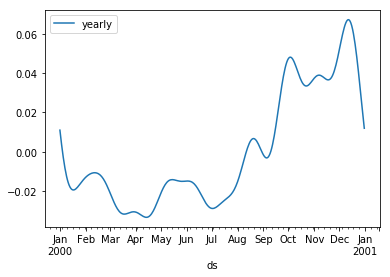

In [52]:
# Shift plot by 280 days
temp=temp.shift(periods=-280, freq='D', axis=0)['2000-01-01' :'2000-12-31']
plt.figure(figsize=(10,5))
temp.plot()

I can see a few peaks. First is in the second part of February. It might be effect of Valentines day :) Another increase of conception rate starts in April. This may be effect of more optimistic spring time. Definetely the majority of chlidren is conceived during cold autumns and winter months. The conception rate start to grow really fast in September. I guess when summer holidays are over it's time to think about more serious things. What's more days become shorter and people use to spend more evenings relaxing at home. But the biggest effect on children conception has Christmas time. I believe the reason is that it's a family time, when people often take many days off work and have time to relax and be together.

### Weekly seasonality

I'll have a look on weekly percentage seasonality effect

In [53]:
# show percentage weekly seasonality
forecast.groupby(forecast['ds'].dt.dayofweek)['weekly'].mean()

ds
0    0.025179
1    0.126966
2    0.106196
3    0.109462
4    0.097813
5   -0.191550
6   -0.274065
Name: weekly, dtype: float64

Text(0.5, 0, 'day of week')

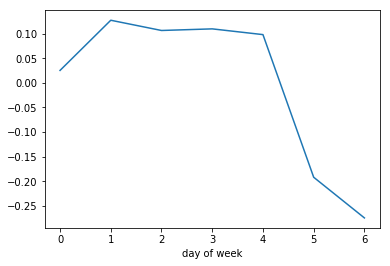

In [54]:
# plot percentage weekly seasonality
forecast.groupby(forecast['ds'].dt.dayofweek)['weekly'].mean().plot()
plt.xlabel('day of week')

There are much less births on weekends than during the week- on Saturday less by 19% than average and on Sunday by 27%. As mentioned earlier the reason must be C-sections and labor inductions carried out during the week whenever possible. I believe there is less stuff available in hospitals during the weekends. The biggest amount of childbirths is observed on Tuesday.

One of the intresting facts obsersered during model creation was that seasonality effect accelerate in time, especially weekly seasonality that has the main effect on predictions. I think it's because weekly seasonality depends on number of cesarean deliveries and cesarean deliveries rate increased significantly during the period in question. The rate was equal to 23% in 1994 and 28% in 2003. 

### Holidays

I'll check what's percentage multipler for each holiday that was either added as default US holiday or specified by me.

In [55]:
# show multiplier for each holiday
holidays_effect=pd.DataFrame(columns=['Holiday','multiplier'])
for col in ['Black_Friday', 'Christmas Day', 'Christmas Day (Observed)',
       'Columbus Day', 'Halloween','Independence Day',
       'Independence Day (Observed)', 'Jan_2nd', 'Jul_5th', 'Labor Day',
       'Leap_Year', 'Martin Luther King, Jr. Day', 'Memorial Day',
       "New Year's Day","New Year's Day (Observed)", 'Thanksgiving', 
       'Veterans Day', 'Veterans Day (Observed)', "Washington's Birthday"]:
    result=pd.Series({'Holiday':col, 'multiplier': forecast[col].min() if forecast[col].min()<0 else forecast[col].max()})
    holidays_effect=holidays_effect.append(result, ignore_index=True)
holidays_effect

,Holiday,multiplier
0,Black_Friday,-0.237540
1,Christmas Day,-0.341214
2,Christmas Day (Observed),-0.159769
3,Columbus Day,-0.025595
4,Halloween,-0.100133
5,Independence Day,-0.231802
6,Independence Day (Observed),-0.199854
7,Jan_2nd,-0.100338
8,Jul_5th,-0.084660
9,Labor Day,-0.310496


<BarContainer object of 19 artists>

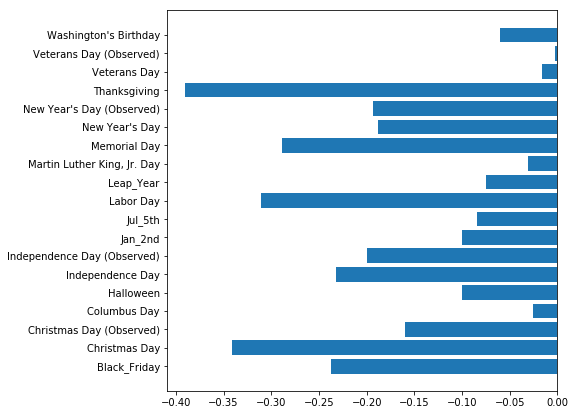

In [56]:
plt.figure(figsize=(7,7))
plt.barh(y=holidays_effect['Holiday'], width=holidays_effect['multiplier'])
#holidays_effect.plot.barh(x='Holiday')

Any holidays result in less children being born. This similar as weekly seasonality is probably caused by not scheduling C-sections nor performing labor induction on those days. The biggest effect has Thanksgiving day with 39% decrease in birhts, Christmas day: 34% and Labor Day: 31%. Quite intresting is 7.5% decrease in number of births on 29th of February on leap years. Maybe women don't won't their children to have Birthday's every 4 years only and are able to persuade doctors to slighlty move dates of cesarean section or labor induction. Let's now see how Christmas period affects births distribution.  

In [57]:
# show extra regressors' influence on births 
forecast[(forecast['ds']>'12-16-2000') & (forecast['ds']<'12-31-2000')][['ds','extra_regressors_multiplicative','Christmas Day']]

,ds,extra_regressors_multiplicative,Christmas Day
2542,2000-12-17,0.071434,0.000000
2543,2000-12-18,0.071434,0.000000
2544,2000-12-19,0.071434,0.000000
2545,2000-12-20,0.071434,0.000000
2546,2000-12-21,0.071434,0.000000
2547,2000-12-22,0.071434,0.000000
2548,2000-12-23,-0.115167,0.000000
2549,2000-12-24,-0.115167,0.000000
2550,2000-12-25,0.000000,-0.341214
2551,2000-12-26,-0.115167,0.000000


As already mentioned Christmas day causes 34% decrease in number of births. Significant decrease of around 11.5% is also observed on 23rd, 24th and 26th of December. This results in increased amount of births before and after those days by 7% on average from 17th till 30th of December. 

### Full moon

The full moon causing more childbirhts seems to be only the myth. I found no proof in data confirming it. 